In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['font.sans-serif']=['SimHei']

## 1. 数据处理

In [3]:
df = pd.read_csv("./iris.data", names=['sepalLength', 'sepalWidth', 'petalLength',
                                       'petalWidth', 'class'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sepalLength  150 non-null    float64
 1   sepalWidth   150 non-null    float64
 2   petalLength  150 non-null    float64
 3   petalWidth   150 non-null    float64
 4   class        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [4]:
df.head()

,sepalLength,sepalWidth,petalLength,petalWidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
feature = df[['sepalLength', 'petalLength']]
label = df[['class']]
encode = LabelEncoder()
label = encode.fit_transform(label)

data = feature.values
feature

C:\Users\DREAM\.conda\envs\ML\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,sepalLength,petalLength
0,5.1,1.4
1,4.9,1.4
2,4.7,1.3
3,4.6,1.5
4,5.0,1.4
...,...,...
145,6.7,5.2
146,6.3,5.0
147,6.5,5.2
148,6.2,5.4


## 2. K-Means聚类

In [6]:
class KMeans:
    def __init__(self, n_clusters=3, max_iters=100, random_seed=None):
        self.n_clusters = n_clusters  # 簇的数量
        self.max_iters = max_iters  # 最大迭代次数
        self.random_seed = random_seed  # 随机种子
        self.centroids = None  # 簇中心

    # 初始化簇中心，随机选择数据中的点作为初始中心
    def _initialize_centroids(self, data):
        # 设置随机种子
        np.random.seed(self.random_seed)
        # 从数据中随机选择self.n_clusters个索引
        indices = np.random.choice(len(data), self.n_clusters, replace=False)
        # 提取选择的索引对应的数据作为初始化的聚类中心
        centroids = data[indices]

        return centroids

    # 将数据点分配到最近的簇
    def _assign_clusters(self, data, centroids):
        # 计算每个数据点到各个聚类中心的距离
        distances = cdist(data, centroids)
        # 返回每个样本对应的聚类标签（最近聚类中心的索引）
        return np.argmin(distances, axis=1)

    # 更新簇中心为每个簇内所有数据点的平均值
    def _update_centroids(self, data, labels):
        new_centroids = np.array([data[labels == k].mean(axis=0) for k in range(self.n_clusters)])
        return new_centroids

    # 训练函数
    def fit(self, data):
        # 初始化簇中心
        self.centroids = self._initialize_centroids(data)
        # 算法迭代主循环
        for _ in range(self.max_iters):
            # 分配样本到最近的簇
            labels = self._assign_clusters(data, self.centroids)
            # 更新簇中心
            new_centroids = self._update_centroids(data, labels)

            # 如果簇中心不再变化，则停止迭代
            if np.all(self.centroids == new_centroids):
                break

            self.centroids = new_centroids

        return labels

    # 计算sse
    def calculate_sse(self, data, labels):
        # 检查是否已经拟合模型并有簇中心
        if self.centroids is None:
            raise ValueError("请先聚类！")

        sse = 0.0
        for i in range(self.n_clusters):
            # 获取属于当前簇的数据点
            cluster_points = data[labels == i]
            # 获取当前簇的中心
            centroid = self.centroids[i]
            # 计算数据点到簇中心的平方距离
            squared_distances = np.sum((cluster_points - centroid) ** 2, axis=1)
            # 将平方距离求和，添加到总的SSE中
            sse += np.sum(squared_distances)

        return sse

    # 查看聚类结果
    def report(self):
        return pd.DataFrame(self.centroids)    

Text(0.5, 1.0, '肘部图')

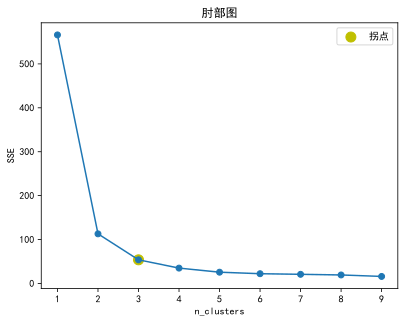

In [7]:
# 尝试不同的n_clusters，以肘部图确定
sse = []

for i in np.arange(1, 10):
    # 实例化
    kmeans = KMeans(n_clusters=i, max_iters=100, random_seed=1314)
    # 开始训练
    labels = kmeans.fit(data)
    # 计算sse
    sse.append(kmeans.calculate_sse(data, labels))

# 绘制sse曲线
plt.plot(range(1, 10), sse, marker='o')
plt.scatter(3, sse[2], color='y', label='拐点', s=100)
plt.xlabel("n_clusters")
plt.xticks(np.arange(1, 10))
plt.ylabel("SSE")
plt.legend()
plt.title("肘部图")

In [8]:
# 实例化
kmeans = KMeans(n_clusters=3, max_iters=100, random_seed=42)
# 开始训练
label_predict = kmeans.fit(data)
# 聚类中心
kmeans.report()

,0,1
0,5.874138,4.393103
1,5.007843,1.494118
2,6.839024,5.678049


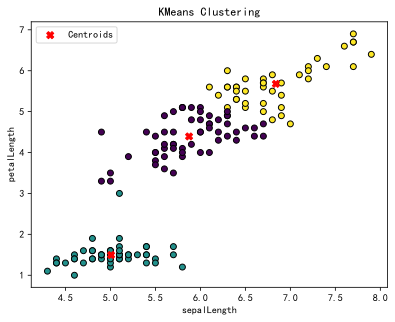

In [9]:
# 绘制聚类结果
plt.scatter(data[:, 0], data[:, 1], c=label_predict, cmap='viridis', edgecolors='k')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], marker='X', s=50, color='red', label='Centroids')
plt.title('KMeans Clustering')
plt.xlabel('sepalLength')
plt.ylabel('petalLength')
plt.legend()
plt.savefig("1.png",dpi=800)
plt.show()

## 3. 混合高斯分布

In [10]:
class GMM:
    def __init__(self, n, max_iters=100, tol=1e-4, random_seed=None):
        self.n = n  # 高斯分布的个数
        self.max_iters = max_iters  # 最大迭代次数
        self.tol = tol  # 收敛阈值
        self.random_seed = random_seed  # 随机种子
        self.weights = None  # 每个高斯分布的权重
        self.means = None  # 每个高斯分布的均值
        self.covariances = None  # 每个高斯分布的协方差矩阵

    # 初始化参数
    def initialize_parameters(self, data):
        np.random.seed(self.random_seed)
        # 随机选择数据中的点作为初始均值
        random_indices = np.random.choice(len(data), self.n, replace=False)
        self.means = data[random_indices]
        # 初始权重相等
        self.weights = np.ones(self.n) / self.n
        # 初始协方差矩阵为数据的协方差
        self.covariances = [np.cov(data.T) for _ in range(self.n)]

    # E-STEP
    def expectation_step(self, data):
        responsibilities = np.zeros((len(data), self.n))

        # 对每个高斯
        for k in range(self.n):
            # 创建一个多元正态分布对象，由参数（均值，(协)方差）
            multivariate_normal_dist = multivariate_normal(mean=self.means[k], cov=self.covariances[k])
            # 计算每个样本属于每个高斯分布的概率，权重乘以每个样本属于当前高斯分布的概率
            responsibilities[:, k] = self.weights[k] * multivariate_normal_dist.pdf(data)

        # 归一化概率
        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)
        return responsibilities

    # M-STEP
    def maximization_step(self, data, responsibilities):
        # 计算每个高斯分布在整体数据集上的权重之和
        total_weight = np.sum(responsibilities, axis=0)
        # 归一，更新权重
        self.weights = total_weight / len(data)
        # 计算均值
        self.means = (responsibilities.T @ data) / total_weight[:, np.newaxis]
        # 更新协方差矩阵
        self.covariances = []
        for k in range(self.n):
            diff = data - self.means[k]
            covariance = np.dot(responsibilities[:, k] * diff.T, diff) / total_weight[k]
            self.covariances.append(covariance)

    # 训练
    def fit(self, data):
        self.initialize_parameters(data)

        for _ in range(self.max_iters):
            # E 步：计算每个样本属于每个高斯分布的概率
            responsibilities = self.expectation_step(data)

            old_means = np.copy(self.means)

            # M 步：更新均值、权重和协方差矩阵
            self.maximization_step(data, responsibilities)

            # 如果均值不再变化，则停止迭代
            if np.linalg.norm(self.means - old_means) < self.tol:
                break

        return responsibilities.argmax(axis=1)

In [11]:
# 实例化
gmm = GMM(n=3, max_iters=100, random_seed=42)
# 训练
predict_labels = gmm.fit(data)

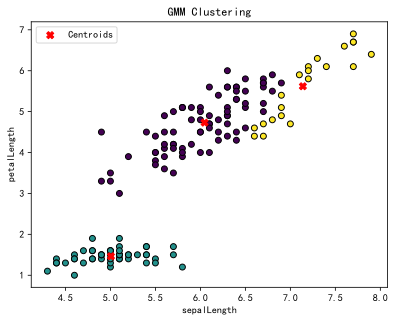

In [12]:
# 绘制混合高斯分布的聚类结果
plt.scatter(data[:, 0], data[:, 1], c=predict_labels, cmap='viridis', edgecolors='k')
plt.scatter(gmm.means[:, 0], gmm.means[:, 1], marker='X', s=50, color='red', label='Centroids')
plt.title('GMM Clustering')
plt.xlabel('sepalLength')
plt.ylabel('petalLength')
plt.legend()
plt.savefig("2.png",dpi=800)
plt.show()

In [15]:
pd.DataFrame({'0': gmm.means[:, 0], '1': gmm.means[:, 1]})

,0,1
0,6.046630,4.730670
1,5.006024,1.463942
2,7.139048,5.619336
